# QOSF Problem-4: The VQE Algorithm (from scratch)

The following code can be used to find the minimum eigenvalue of **any** 2-qubit Hamiltonian using the Variational Quantum Eigensolver (VQE) algorithm. We will be coding using IBM's open-source Quantum SDK QISKit. 

In [1]:
import numpy as np 
np.random.seed(20)

## Hamiltonian

In [2]:
# building the Hamiltonian 
# this code will work for any 2-qubit (4x4) Hamiltonian

H = np.zeros((4, 4))
H[0][0], H[1][2], H[2][1], H[3][3] = 1, -1, -1, 1
print(H)

[[ 1.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]]


Now, we will decompose the Hamiltonian into Pauli terms. Any 2-qubit Hamiltoninan $\textsf{H}$ can be written as a sum of Pauli-strings as follows - 
$$\displaystyle \textsf{H} = \sum_{i, j=0}^3 a_{ij}\textsf{P}_i\otimes\textsf{P}_j$$where, $(\textsf{P}_0, \textsf{P}_1, \textsf{P}_2, \textsf{P}_3) = (\textsf{I}, \textsf{X}, \textsf{Y}, \textsf{Z})$.

Then, using the Hilbert-Schmidt Inner Product (or, Trace Inner Product), we can write - $$a_{ij} = \frac{1}{4}{\rm Tr}\,\left[(\textsf{P}_i\otimes\textsf{P}_j)\textsf{H}\right]$$

In [3]:
# creating the list of Pauli Matrices
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

PAULI = [I, X, Y, Z]

print(I,'\n', X,'\n', Y,'\n', Z)

[[1 0]
 [0 1]] 
 [[0 1]
 [1 0]] 
 [[ 0.+0.j -0.-1.j]
 [ 0.+1.j  0.+0.j]] 
 [[ 1  0]
 [ 0 -1]]


In [4]:
# finding the Pauli-coefficients using the Trace Inner Product 

dim = (4, 4)

# coeficients matrix 
coeffs = np.zeros(dim)*1j

for i in range(dim[0]):
    for j in range(dim[1]):
        
        # trace inner product
        coeffs[i][j] = np.trace(np.kron(PAULI[i], PAULI[j])@H)/4

print(coeffs)

[[ 0.5+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0.5+0.j]]


We will use Numpy's linear algebra module to find the actual eigenvalues. This will serve as a reference to find the error in our computed value. 

In [5]:
eigs = np.linalg.eigvals(H)
min_eig = np.amin(eigs)
print('All Eigenvalues', eigs)
print('Minimum Eigenvalue:', min_eig)

All Eigenvalues [ 1. -1.  1.  1.]
Minimum Eigenvalue: -1.0


In [6]:
np.linalg.eig(H)

(array([ 1., -1.,  1.,  1.]),
 array([[ 0.        ,  0.        ,  1.        ,  0.        ],
        [-0.70710678,  0.70710678,  0.        ,  0.        ],
        [ 0.70710678,  0.70710678,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

For the given Hamiltonian, the lowest eigenvalue is $(-1)$, which occurs for the state - 
$$\begin{bmatrix}0\\ 1/\sqrt{2} \\ 1/\sqrt{2} \\0\end{bmatrix} = \frac{1}{\sqrt{2}}|10\rangle + \frac{1}{\sqrt{2}}|01\rangle$$ 

## Creating Ansatz

In [7]:
# we will be building and running circuits in Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

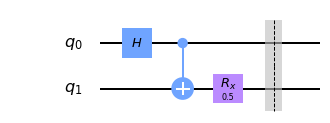

In [8]:
# creating ansatz circuit 
def get_ansatz(param):
    circ = QuantumCircuit(2)
    
    circ.h(0)
    circ.cx(0, 1)
    circ.rx(param[0], 1)
    
    circ.barrier()
    
    return circ

# checking circuit
get_ansatz([0.5]).draw(output='mpl')

In [9]:
# generating the VQE Measurement Circuit for a Pauli String
def get_measurement_circuit(string):
    """Generates a Pauli-Measurement Circuit.
        :string: is a 2-element list or tuple, indicating the measurement-basis of the corresponding qubit
        input the following numbers for the corresponding basis - 
        0 - I, 1 - X, 2 - Y, 3 - Z"""

    meas = QuantumCircuit(2, 2)
    
    for i in range(len(string)):
        if string[i]==1:
            # measuring in X-basis
            meas.h(i)
        elif string[i]==2:
            # measuring in Z-basis 
            meas.u2(0, (np.pi)/2, i)
    
    # default measurement is in Z-basis
    # so, don;t have to do anything for string[i]=3

    meas.measure([0, 1], [0, 1])
    
    return meas

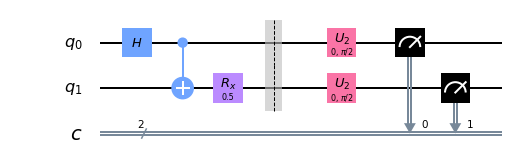

In [10]:
# generating a measurement circuit for YY measurement to check 
(get_ansatz([0.5]) + get_measurement_circuit([2, 2])).draw(output='mpl')

# Optimization

## Configuring the Simulator

In [11]:
# Import Aer - qiskit's simulation module
from qiskit import Aer, execute
# Run the quantum circuit on a simulator backend
backend = Aer.get_backend('qasm_simulator')

## Cost Function

In [12]:
# making a 4-element probability vector from qiskit's dictionary of simulation results

def get_probability_distribution(counts):
    output_distr = np.zeros(4)
    
    for i in range(4):
        # generate reversed bit-string of i to access the counts dictionary
        output_string = format(i, '02b')[::-1]
        if output_string in counts:
            output_distr[i] = counts[output_string]
            # print(output_distr)
    
    # normalizing the probability distribution
    output_distr = output_distr/np.sum(output_distr)
    return output_distr

# checking
count = {'01': 500, '11':500}
get_probability_distribution(count)

array([0. , 0. , 0.5, 0.5])

In [13]:
# list of eigen-values of each Pauli-Matrix and I
# we will need them to add the outcome probabilites with the required sign
pauli_eigen = [np.array([1, 1]), np.array([1, -1]), np.array([1, -1]), np.array([1, -1])]
print(pauli_eigen)

[array([1, 1]), array([ 1, -1]), array([ 1, -1]), array([ 1, -1])]


In [14]:
# this is the cost-function
def objective_function(params):
    """Outputs the expectation value of the Hamiltonian for the state 
    corresponding to the parameters (params)"""
    
    # Obtain a quantum circuit instance from the paramters
    circ = get_ansatz(params)
    
    cost = 0
    for i in range(dim[0]): 
        for j in range(dim[1]):
            # no-need to simulate if the Pauli-Weight is 0
            if coeffs[i][j]==0:
                continue
            
            # Obtain a measurement circuit for the Pauli-string
            test = circ + get_measurement_circuit([i, j])    

            # Create a Quantum Program for execution
            result = execute(test, backend, shots=NUM_SHOTS).result()

            # Obtain the counts for each measured state, and convert those counts into a probability vector
            output_distr = get_probability_distribution(result.get_counts())
            # print('Output Distribution', output_distr)
            
            # computing the sign vector to add the probabilities
            sign_vector = np.kron(pauli_eigen[i], pauli_eigen[j])
            # print('Sign Vector', sign_vector)
                        
            cost += coeffs[i][j]*(np.dot(sign_vector, output_distr))
            # print('Present cost is', cost, '\n')
    
    return cost.real

In [15]:
# checking if the cost-function works
NUM_SHOTS = 1000
objective_function([np.pi])

-1.0

## Configuring Optimizer

In [16]:
from qiskit.aqua.components.optimizers import COBYLA, SPSA
import time

# Initialize the Contrained Optimization BY Linear Approximation (COBYLA) optimizer
optimizer = COBYLA(maxiter=1000)

# Create the initial parameters
INITIAL = np.random.rand(1)

# bounds of the parameters
BOUNDS = [(0, 2*np.pi)]*len(INITIAL)

In [17]:
NUM_SHOTS = 500
print("Sampling Circuit", NUM_SHOTS, "times.")

# timing simulation
start = time.time()

# optimize circuit
ret = optimizer.optimize(num_vars=len(INITIAL), objective_function=objective_function, 
                     initial_point=INITIAL)

print("Circuit Optimized!", round(time.time()-start), "seconds elapsed.\n")

print('Value of parameter', (ret[0]/np.pi)%2, '\b*pi\n', 'Minimum eigenvalue', ret[1],'\n')
print('Error = ', np.abs((ret[1]-min_eig)/min_eig), '%')

Sampling Circuit 500 times.
Circuit Optimized! 0 seconds elapsed.

Value of parameter [1.00287693]*pi
 Minimum eigenvalue -1.0 

Error =  0.0 %


## References
[1] Quantum Computation and Quantum Information, M. A. Nielsen & I. L. Chuang 

[2] Simulating Molecules using VQE, Qiskit Textbook 

[3] Variational Quantum Eigensolver, Davit Khachatryan